# Imports and Setup
The `librosa` library is used to load the raw audio and convert it to a Log Mel Spectrogram, while `pandas` and `numpy` help manage metadata and numerical operations. `matplotlib` and `seaborn` are used for data visualization, and `sklearn` provides machine learning utilities. `google.colab` provides access to the dataset on Google Drive to save feature extraction time.

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import librosa
import librosa.display
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

# Ignore warnings
warnings.simplefilter("ignore")

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define paths
PROJECT_ROOT = "/content/drive/MyDrive/emotion_recognition_project"
SPEC_DIR = os.path.join(PROJECT_ROOT, "mel_spectrograms")
os.makedirs(SPEC_DIR, exist_ok=True)

In [4]:
# Using my personal paths to make the code work
METADATA_PATH = os.path.join(PROJECT_ROOT, "processed_metadata.csv")
TRAIN_NPZ_PATH = os.path.join(SPEC_DIR, "mel_train.npz")
VAL_NPZ_PATH = os.path.join(SPEC_DIR, "mel_val.npz")

print(f"Loading metadata from: {METADATA_PATH}")

Loading metadata from: /content/drive/MyDrive/emotion_recognition_project/processed_metadata.csv


# Data Loading and Pre-processing
`metadata` is a dataframe containing the audio file paths, labels, and quality assurance flags (e.g. `processed_success`). Only samples that are successfully processed are kept (all files were successfully processed). We also map categorical emotion labels into integers for classification [from emotion label strings ('happy', 'sad'...) to integers (0, 1, ...)].

In [5]:
# Load metadata
metadata = pd.read_csv(METADATA_PATH)
print(f"Loaded {len(metadata)} audio files metadata")

Loaded 12162 audio files metadata


In [6]:
# Check if we have the processed_path column
if 'processed_path' not in metadata.columns:
    print("Error: 'processed_path' column not found in metadata. Make sure you've run the preprocessing step.")
else:
    print(f"Found {metadata['processed_path'].notna().sum()} valid processed audio files")


Found 12162 valid processed audio files


In [7]:
# Encode labels
le = LabelEncoder()
metadata["label_enc"] = le.fit_transform(metadata["label"])
print(f"Emotion labels encoded: {dict(zip(le.classes_, range(len(le.classes_))))}")

Emotion labels encoded: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


To evaluate the model performance, we split the dataset into training and testing. We stratified the splitting process by labels to ensure that the output datasets have the same label distribution as the original dataset. We also fixed the random seed for reproducibility and fair comparison between models by each team member. These subsets are loaded and converted to Log Mel Spectrogram using the `librosa` library. We used a sample rate of 16,000 Hz, and any audio files longer than 4 seconds are truncated. For the ones shorter than 4 seconds, we padded them with zeros to generate samples with consistent length. The extracted features are then saved as .npy files for future access.

In [8]:
# Split data into train and validation sets
meta_train, meta_val = train_test_split(
    metadata,
    test_size=0.2,
    stratify=metadata["label"],
    random_state=42
)

print(f"Training set: {len(meta_train)} samples")
print(f"Validation set: {len(meta_val)} samples")

Training set: 9729 samples
Validation set: 2433 samples


In [9]:
# feature extraciton functions
def load_audio_segment(path, sr=16000, duration=4.0):
    """Load audio file with fixed duration."""
    max_len = int(sr * duration)
    y, _ = librosa.load(path, sr=sr, duration=duration)
    if len(y) < max_len:
        y = np.pad(y, (0, max_len - len(y)))
    return y[:max_len]

def extract_mel(y, sr=16000, max_len=126):
    """Extract log mel spectrogram with fixed time dimension."""
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    spec = librosa.power_to_db(S, ref=np.max)
    if spec.shape[1] < max_len:
        pad_width = max_len - spec.shape[1]
        spec = np.pad(spec, ((0, 0), (0, pad_width)), mode="constant")
    else:
        spec = spec[:, :max_len]
    return spec

In [10]:
# Mel Spectogram extraction
if not (os.path.exists(TRAIN_NPZ_PATH) and os.path.exists(VAL_NPZ_PATH)):
    print("\nProcessing audio files and generating mel spectrograms...")

    batch_size = 500
    mel_batches_train = []
    temp_batch_train = []
    failed_files_train = 0

    # Process training data
    for i, row in tqdm(meta_train.iterrows(), total=len(meta_train), desc="Train Data"):
        try:
            # Use the processed_path column which contains the path to processed audio files
            path = row["processed_path"]
            y = load_audio_segment(path)
            mel = extract_mel(y)
            temp_batch_train.append(mel)

            if len(temp_batch_train) == batch_size or i == meta_train.index[-1]:
                if temp_batch_train:  # Check if the batch is not empty
                    mel_batches_train.append(np.expand_dims(np.array(temp_batch_train), axis=-1))
                    temp_batch_train = []
        except Exception as e:
            failed_files_train += 1
            if failed_files_train <= 5:  # Only print the first few errors to avoid cluttering the output
                print(f"Error processing {path}: {e}")
            elif failed_files_train == 6:
                print("Suppressing further error messages...")

    # Process validation data
    mel_batches_val = []
    temp_batch_val = []
    failed_files_val = 0

    for i, row in tqdm(meta_val.iterrows(), total=len(meta_val), desc="Val Data"):
        try:
            # Use the processed_path column which contains the path to processed audio files
            path = row["processed_path"]
            y = load_audio_segment(path)
            mel = extract_mel(y)
            temp_batch_val.append(mel)

            if len(temp_batch_val) == batch_size or i == meta_val.index[-1]:
                if temp_batch_val:  # Check if the batch is not empty
                    mel_batches_val.append(np.expand_dims(np.array(temp_batch_val), axis=-1))
                    temp_batch_val = []
        except Exception as e:
            failed_files_val += 1
            if failed_files_val <= 5:  # Only print the first few errors to avoid cluttering the output => Mak
                print(f"Error processing {path}: {e}")
            elif failed_files_val == 6:
                print("Suppressing further error messages...")

    # Concatenate batches
    if mel_batches_train:
        X_train = np.concatenate(mel_batches_train, axis=0)
        y_train = meta_train["label_enc"].values[:len(X_train)]  # Ensure label count matches spectrogram count

        print(f"Training spectrograms: {X_train.shape}")
        print(f"Training labels: {y_train.shape}")

        # Save training data
        np.savez_compressed(TRAIN_NPZ_PATH, X=X_train, y=y_train)
        print(f"Saved training spectrograms to {TRAIN_NPZ_PATH}")
    else:
        print("Error: No training spectrograms were generated!")

    if mel_batches_val:
        X_val = np.concatenate(mel_batches_val, axis=0)
        y_val = meta_val["label_enc"].values[:len(X_val)]  # Ensure label count matches spectrogram count

        print(f"Validation spectrograms: {X_val.shape}")
        print(f"Validation labels: {y_val.shape}")

        # Save validation data
        np.savez_compressed(VAL_NPZ_PATH, X=X_val, y=y_val)
        print(f"Saved validation spectrograms to {VAL_NPZ_PATH}")
    else:
        print("Error: No validation spectrograms were generated!")

    print(f"\nProcessing summary:")
    print(f"- Failed training files: {failed_files_train}/{len(meta_train)}")
    print(f"- Failed validation files: {failed_files_val}/{len(meta_val)}")
    print("\nMel spectrograms extraction completed.")
else:
    print("\nUsing cached mel spectrograms.")


Using cached mel spectrograms.


In [11]:
# --- LOAD DATA ---
print("\nLoading mel spectrograms for training...")

train = np.load(TRAIN_NPZ_PATH)
val = np.load(VAL_NPZ_PATH)

X_train = train["X"]
y_train = train["y"]
X_val = val["X"]
y_val = val["y"]


Loading mel spectrograms for training...


In [12]:
# Convert to categorical (one-hot encoding)
num_classes = len(le.classes_)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

print(f"Training data: {X_train.shape}, {y_train_cat.shape}")
print(f"Validation data: {X_val.shape}, {y_val_cat.shape}")

Training data: (9729, 128, 126, 1), (9729, 7)
Validation data: (2433, 128, 126, 1), (2433, 7)


In [13]:
# Create TensorFlow datasets
df_train = tf.data.Dataset.from_tensor_slices((X_train, y_train_cat)).shuffle(1000).batch(128).prefetch(tf.data.AUTOTUNE)
df_val = tf.data.Dataset.from_tensor_slices((X_val, y_val_cat)).shuffle(1000).batch(128).prefetch(tf.data.AUTOTUNE)

# Utility Functions
This section provides helper functions to plot the training/validation loss and accuracy. Evaluation metrics and confusion matrices are also defined here, enabling standardized performance reporting across all models.

In [14]:
# Helper functions for analysis
def plot_results(hist):
    """Plot training and validation accuracy and loss."""
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(hist.history["accuracy"], label="Training")
    ax[0].plot(hist.history["val_accuracy"], label="Validation")
    ax[0].set_title("Accuracy")
    ax[0].legend()
    ax[1].plot(hist.history["loss"], label="Training")
    ax[1].plot(hist.history["val_loss"], label="Validation")
    ax[1].set_title("Loss")
    ax[1].legend()
    plt.show()

def get_confusion_matrix(dataset, model, title="Confusion Matrix"):
    """Generate and display confusion matrix."""
    # Generate predictions and collect true labels
    y_true_all = []
    y_pred_all = []

    # Get predictions and true labels in matching order from each batch
    for x_batch, y_batch in dataset:
        # Get predictions
        batch_pred = model.predict(x_batch, verbose=0)
        y_pred = np.argmax(batch_pred, axis=1)

        # Get true labels from this same batch
        y_true = np.argmax(y_batch.numpy(), axis=1)

        # Extend our collection
        y_true_all.extend(y_true)
        y_pred_all.extend(y_pred)

    # Generate confusion matrix
    matrix = confusion_matrix(y_true_all, y_pred_all)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true_all, y_pred_all, target_names=le.classes_))

    return y_true_all, y_pred_all, matrix

# Model Training
## Best Model
Although various models are attempted, we only keep the best performing model as a final results. The best model has the following components.
1. 4 Sequential Blocks, where each has the following layers.
    - 3*3 Convolutional layer with increasing number of filters: 32, 64, 128, 256
    - Batch Normalization Layer
    - ReLU activation
    - Dropout layer with increasing dropout probabily: 0%, 0%, 10%, 20%
2. Fully Connected classifier
    - Dense layer with 256 units
    - Dropout layer with a rate of 30%
    - A softmax output layer for final classification

Note that this model is also the best performing model for the MFCC feature extraction, allowing us to fairly compare the two feature extraction methods.

In [22]:
# CNN Model used in the mfcc for comparaison
def build_zoe_cnn(input_shape=(128, 126, 1), num_classes=num_classes):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=input_shape))

    for filters, dropout in zip([32, 64, 128, 256], [0, 0, 0.1, 0.2]):
        model.add(tf.keras.layers.Conv2D(filters, (3, 3), padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        model.add(tf.keras.layers.Dropout(dropout))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    return model

In [23]:
# Build Zoe's model
model2 = build_zoe_cnn(input_shape=X_train.shape[1:], num_classes=num_classes)
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 63, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 31, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 31, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 32, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 16, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14336)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,670,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             

 Total params: 4,061,831 (15.49 MB)

 Trainable params: 4,060,871 (15.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [24]:
# Compile model
model2.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_acc')]
)

# Define callbacks for model
callbacks2 = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(os.path.join(SPEC_DIR, "best_model2.keras"),
                                      save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)
]

In [25]:
# Train Zoe's model
print("\nTraining CNN in mfcc model...")
hist2 = model2.fit(
    df_train,
    validation_data=df_val,
    epochs=70,
    callbacks=callbacks2
)


Training CNN in mfcc model...
Epoch 1/70
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.2379 - loss: 2.8783 - top_3_acc: 0.5906
Epoch 1: val_accuracy improved from -inf to 0.23551, saving model to /content/drive/MyDrive/emotion_recognition_project/mel_spectrograms/best_model2.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 187ms/step - accuracy: 0.2385 - loss: 2.8722 - top_3_acc: 0.5914 - val_accuracy: 0.2355 - val_loss: 2.3945 - val_top_3_acc: 0.5586 - learning_rate: 1.0000e-04
Epoch 2/70
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3806 - loss: 2.0377 - top_3_acc: 0.7592
Epoch 2: val_accuracy improved from 0.23551 to 0.42540, saving model to /content/drive/MyDrive/emotion_recognition_project/mel_spectrograms/best_model2.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.3811 - loss: 2.0365 - top_3_acc: 0.7594 - val_accuracy: 0.4254 - val_loss: 2.0982 - val_top_3_acc: 0.7928 - learning_rate: 1.0000e-04
Epoch 3/70
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.45

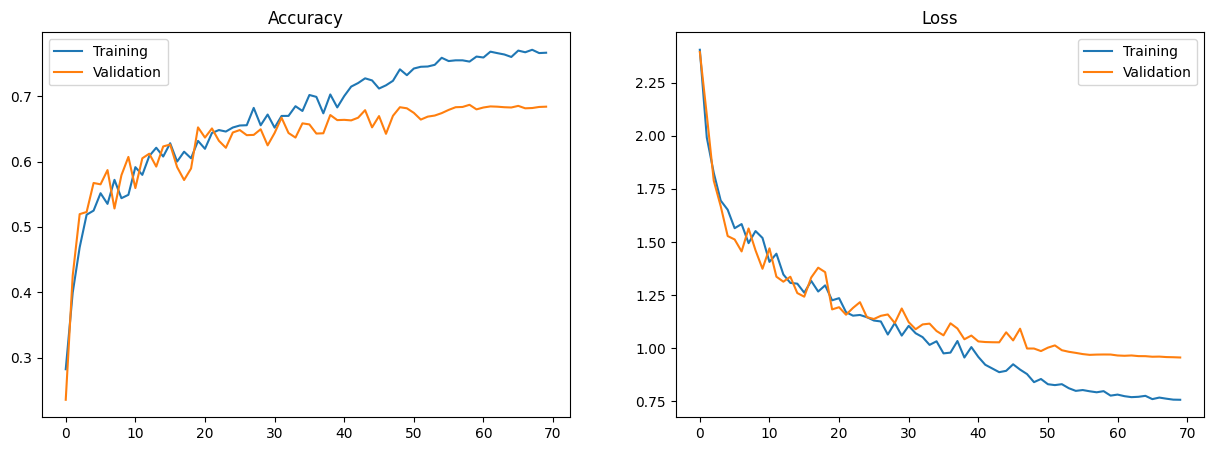

In [26]:
# Plot Zoe's model training history
plot_results(hist2)

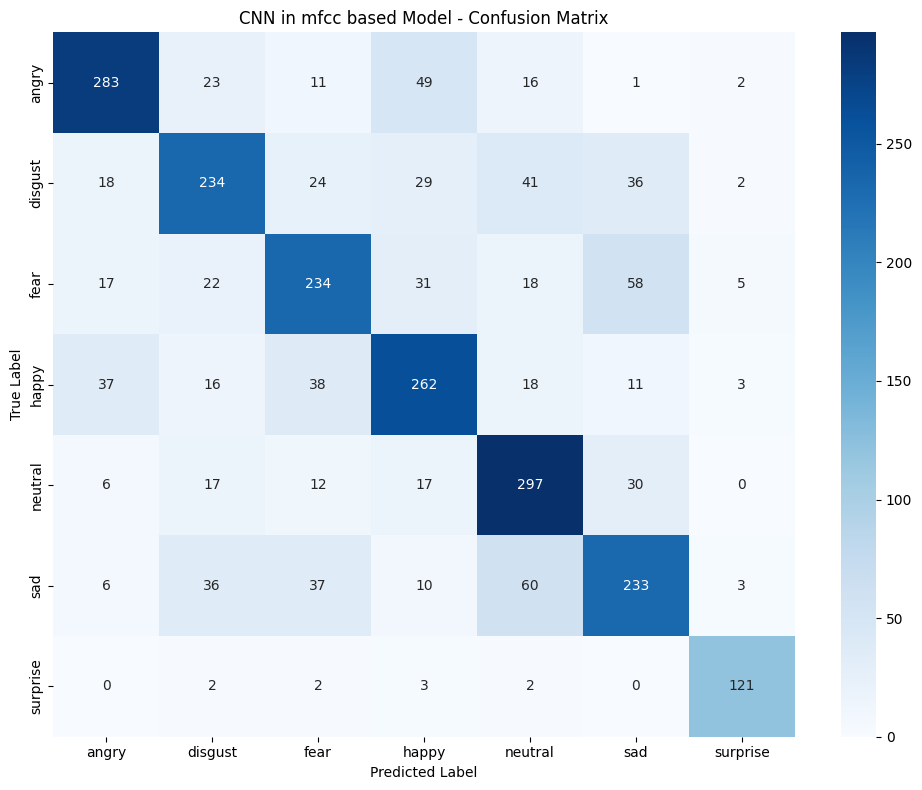


Classification Report:
              precision    recall  f1-score   support

       angry       0.77      0.74      0.75       385
     disgust       0.67      0.61      0.64       384
        fear       0.65      0.61      0.63       385
       happy       0.65      0.68      0.67       385
     neutral       0.66      0.78      0.71       379
         sad       0.63      0.61      0.62       385
    surprise       0.89      0.93      0.91       130

    accuracy                           0.68      2433
   macro avg       0.70      0.71      0.70      2433
weighted avg       0.68      0.68      0.68      2433



In [27]:
# Generate confusion matrix for Zoe's model
y_true2, y_pred2, matrix2 = get_confusion_matrix(df_val, model2, title="CNN in mfcc based Model - Confusion Matrix")

In [28]:
# Save Zoe's best model run
model2_save_path = os.path.join(PROJECT_ROOT, "emotion_recognition_model2.keras")
model2.save(model2_save_path)
print(f"\nCNN in mfcc based model saved to: {model2_save_path}")


CNN in mfcc based model saved to: /content/drive/MyDrive/emotion_recognition_project/emotion_recognition_model2.keras


### Discussion
This section evaluates the performance of deep CNN pipeline using the Log Mel Spectrogram feature extraction. 
### Key Results:
- **Accuracy**: 68.39%
- **Top 3 Accuracy**: 93.05%
- **Feature Dimensionality**: 128*126
- **Classifier**: Logistic Regression

### Observations
- Excellent performance on **surprise**, as observed from high precision (89%), recall (93%), and F1-score (91%), presumably due to the strong emotional intensity.
- An overall F1 score of 70% indicates a moderate fairly uniform performance across most classes, avoiding extreme imbalances
- **Fear** and **disgust** have F1 scores of 63-64%, meaning the model is underperforming and have confused these emotions with others

### Takeaways
This Log Mel Spectrogram based CNN has a solid performance across most emotion categories. Log Mel Spectrograms provide a rich time-frequency representation, but are typically treated as static 2D images in CNNs, which limits there ability to capture temporal dependencies. While the same model reached a validation accuracy of 70% on MFCC data, the valiation accuracy remains at 68.39% on Log Mel Spectrogram. This could stems from the fact that each Log Mel Spectrogram value is correlated and contains irrelevant information, and therefore is more prone to overfitting.
